In [1]:
import pandas as pd
import logging
from typing import Optional
import matplotlib.pyplot as plt

import numpy as np

import seaborn as sns
from scipy import stats
from statsmodels.graphics.gofplots import qqplot

## Homework



The goal of this homework is to train a simple model for predicting the duration of a ride - similar to what we did in this module.


## Q1. Downloading the data

We'll use [the same NYC taxi dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page),
but instead of "**Green** Taxi Trip Records", we'll use "**Yellow** Taxi Trip Records".

Download the data for January and February 2023.

Read the data for January. How many columns are there?

* 16
* 17
* 18
* 19




In [2]:
download = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')
len(download.columns)

19

There are 19 columns in January 2023

## Q2. Computing duration

Now let's compute the `duration` variable. It should contain the duration of a ride in minutes. 

What's the standard deviation of the trips duration in January?

* 32.59
* 42.59
* 52.59
* 62.59

In [3]:

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def read_dataframe(df: pd.DataFrame) -> Optional[pd.DataFrame]:
    """Process taxi trip dataframe with type validation and logging.
    
    Args:
        df: Raw DataFrame with taxi trip columns.
    
    Returns:
        Processed DataFrame or None if validation fails with duration as a new feature.
    """
    try:
        # Validate input
        required_columns = {'tpep_pickup_datetime', 'tpep_dropoff_datetime', 
                           'PULocationID', 'DOLocationID'}
        if not required_columns.issubset(df.columns):
            missing = required_columns - set(df.columns)
            logger.error(f"Missing required columns: {missing}")
            return None

        
        df = df.copy()  
        df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
        df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
        logger.info("Datetime conversion completed")

        
        df['duration'] = (
            df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
        ).dt.total_seconds() / 60
        logger.info("Duration calculation completed")

        
        df = df[(df['duration'] >= 1) & (df['duration'] <= 60)].copy()
        logger.info(f"Filtered to {len(df)} valid trips")

        
        categorical = ['PULocationID', 'DOLocationID']
        df[categorical] = df[categorical].astype('string')  
        logger.info("Type conversion to string completed")

        return df

    except Exception as e:
        logger.error(f"Processing failed: {str(e)}", exc_info=True)
        return None

In [4]:
df = read_dataframe(download)

duration_std = df['duration'].std()
print(f"Standard Deviation of Trip Duration: {duration_std:.2f} minutes")

INFO:__main__:Datetime conversion completed
INFO:__main__:Duration calculation completed
INFO:__main__:Filtered to 3009173 valid trips
INFO:__main__:Type conversion to string completed


Standard Deviation of Trip Duration: 9.94 minutes


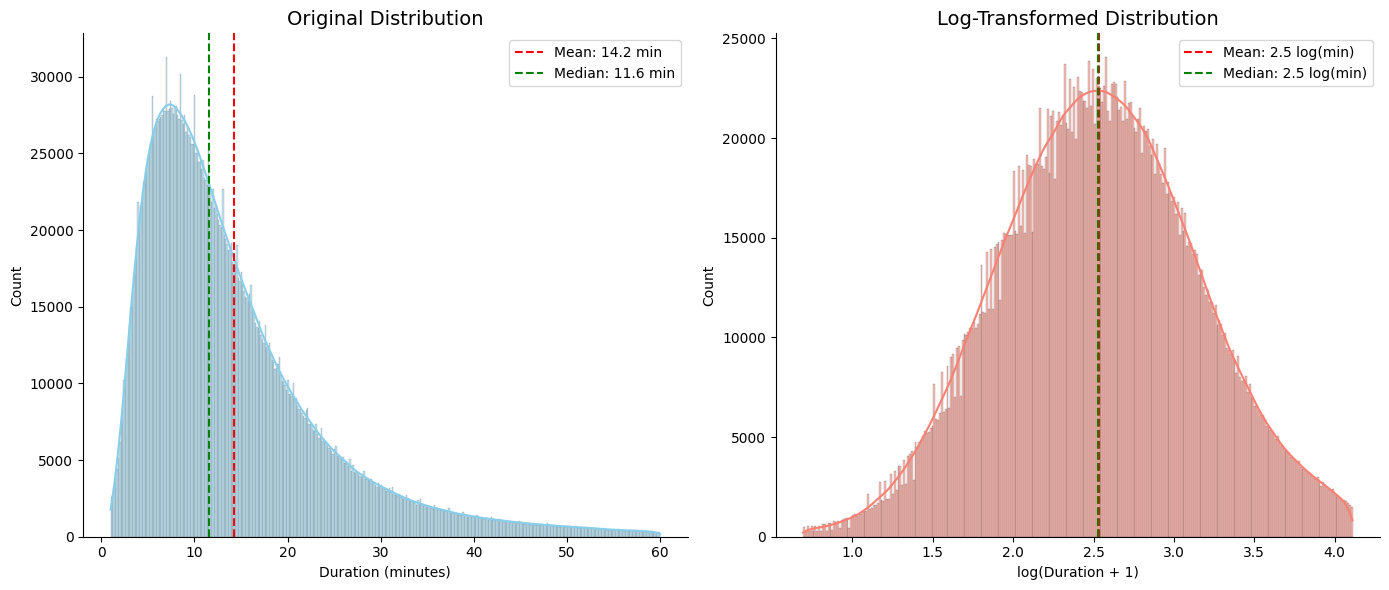

In [5]:
plt.figure(figsize=(14, 6))

# Original 
plt.subplot(1, 2, 1)
sns.histplot(df['duration'], kde=True, color='skyblue')
plt.axvline(df['duration'].mean(), color='red', linestyle='--', label=f'Mean: {df["duration"].mean():.1f} min')
plt.axvline(df['duration'].median(), color='green', linestyle='--', label=f'Median: {df["duration"].median():.1f} min')
plt.title('Original Distribution', fontsize=14)
plt.xlabel('Duration (minutes)')
plt.ylabel('Count')
plt.legend()

# Log-Transformed 
plt.subplot(1, 2, 2)
log_duration = np.log1p(df['duration'])  
sns.histplot(log_duration, kde=True, color='salmon')
plt.axvline(log_duration.mean(), color='red', linestyle='--', label=f'Mean: {log_duration.mean():.1f} log(min)')
plt.axvline(log_duration.median(), color='green', linestyle='--', label=f'Median: {log_duration.median():.1f} log(min)')
plt.title('Log-Transformed Distribution', fontsize=14)
plt.xlabel('log(Duration + 1)')
plt.ylabel('Count')
plt.legend()

sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))




 

sns.boxplot(x=log_duration, color='lightblue', whis=1.5)


plt.axvline(log_duration.median(), color='red', linestyle='--', label='Median')
plt.title('Trip Duration (Log Scale)', fontsize=14)
plt.xlabel('log(1 + Duration in minutes)')


log_ticks = [0, 1, 2, 3, 4]  
plt.xticks(log_ticks, [f"{np.expm1(x):.0f}" for x in log_ticks])
plt.gca().set_xticklabels([f"{np.expm1(x):.0f} min" for x in log_ticks], rotation=45)
plt.ylabel('')

sns.despine()
plt.tight_layout()
plt.show()

KeyError: 'log_duration'

<Figure size 1200x600 with 0 Axes>

a log transformation will help us predict trip duration more effectively

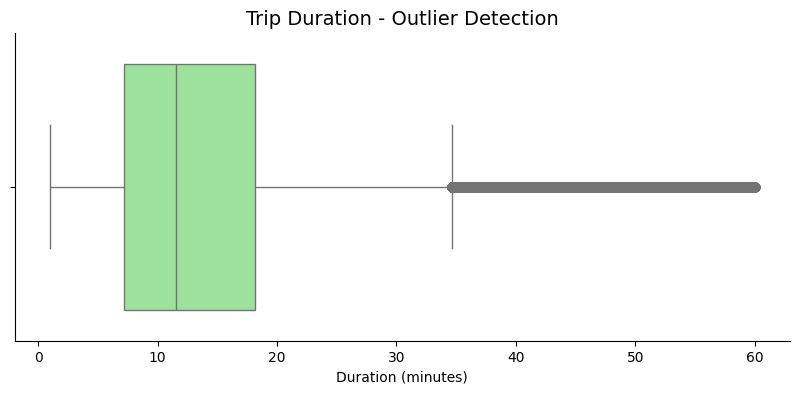

Outlier thresholds:
Below -9.2 min or above 34.6 min


In [6]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['duration'], color='lightgreen')
plt.title('Trip Duration - Outlier Detection', fontsize=14)
plt.xlabel('Duration (minutes)')
sns.despine()
plt.show()


q1, q3 = df['duration'].quantile([0.25, 0.75])
iqr = q3 - q1
print(f"Outlier thresholds:\nBelow {q1 - 1.5*iqr:.1f} min or above {q3 + 1.5*iqr:.1f} min")

We see we have plenty of outliers using a traditional IQR. This seems restrictive.

<Figure size 1000x600 with 0 Axes>

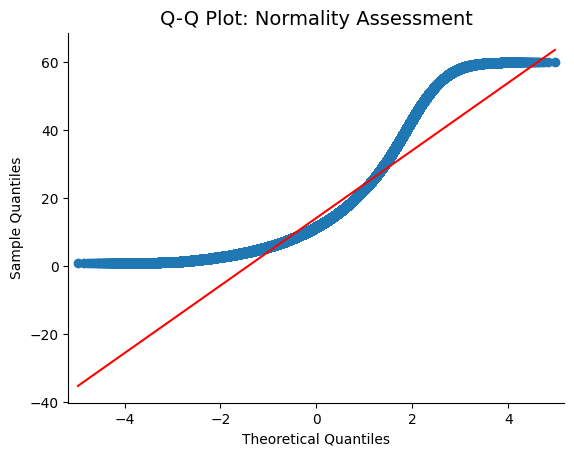

Normality test: p-value = 0.000 (Not normal)


In [7]:
plt.figure(figsize=(10, 6))
qqplot(df['duration'], line='s')  
plt.title('Q-Q Plot: Normality Assessment', fontsize=14)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
sns.despine()
plt.show()

# Normality test
stat, p = stats.shapiro(df['duration'].sample(min(5000, len(df))))  # Limit sample size for performance
print(f"Normality test: p-value = {p:.3f} ({'Not normal' if p < 0.05 else 'Normal'})")

In [8]:
def calculate_optimal_range(series: pd.Series, iqr_factor: float = 1.5) -> tuple[float, float]:
    """
    Dynamically calculates display range using IQR with adjustable sensitivity.
    
    Args:
        series: Input data (trip durations)
        iqr_factor: Controls outlier tolerance (1.5=standard, higher=wider range)
    
    Returns:
        (lower_bound, upper_bound) for optimal visualization
    """
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower_bound = max(series.min(), q1 - iqr_factor * iqr)
    upper_bound = min(series.max(), q3 + iqr_factor * iqr)
    return lower_bound, upper_bound




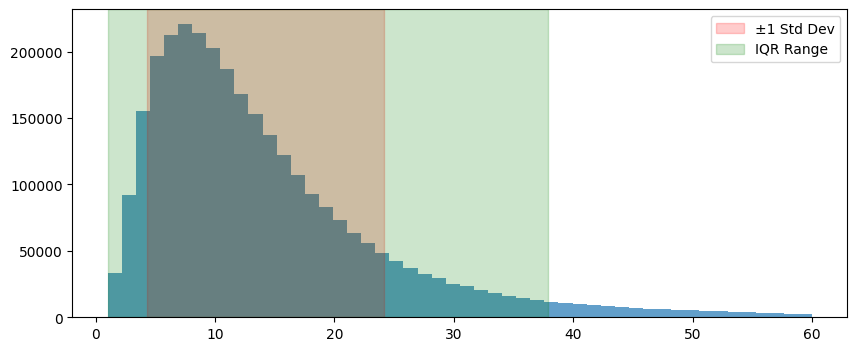

In [11]:
lower, upper = calculate_optimal_range(df['duration'], iqr_factor=1.8)
plt.figure(figsize=(10,4))
plt.hist(df['duration'], bins=50, alpha=0.7)
plt.axvspan(df['duration'].mean() - duration_std, 
            df['duration'].mean() + duration_std, 
            color='red', alpha=0.2, label='±1 Std Dev')
plt.axvspan(lower, upper, color='green', alpha=0.2, label='IQR Range')
plt.legend()
plt.show()


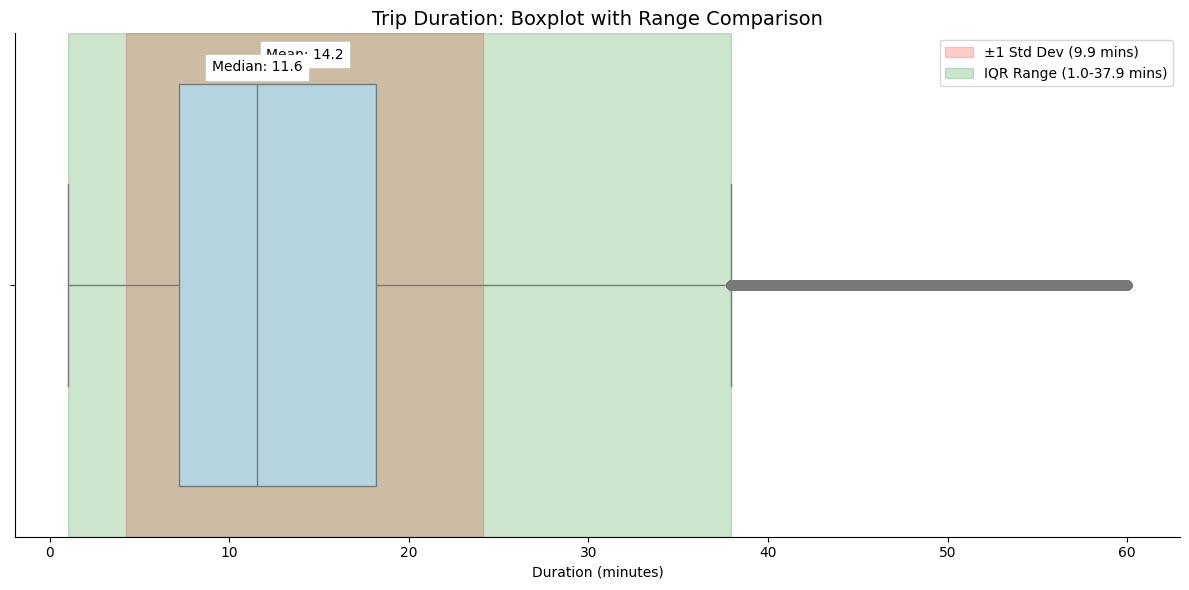

In [12]:
plt.figure(figsize=(12, 6))


sns.boxplot(x=df['duration'], whis=1.8, color='lightblue')  # whis=1.8 matches our IQR factor


plt.axvspan(df['duration'].mean() - duration_std, 
            df['duration'].mean() + duration_std, 
            color='red', alpha=0.2, label=f'±1 Std Dev ({duration_std:.1f} mins)')
plt.axvspan(lower, upper, 
            color='green', alpha=0.2, label=f'IQR Range ({lower:.1f}-{upper:.1f} mins)')


plt.text(df['duration'].mean(), plt.ylim()[1]*0.9, 
         f"Mean: {df['duration'].mean():.1f}", ha='center', backgroundcolor='white')
plt.text(df['duration'].median(), plt.ylim()[1]*0.85, 
         f"Median: {df['duration'].median():.1f}", ha='center', backgroundcolor='white')

plt.title('Trip Duration: Boxplot with Range Comparison', fontsize=14)
plt.xlabel('Duration (minutes)')
plt.legend(bbox_to_anchor=(1, 1))
sns.despine()
plt.tight_layout()
plt.show()

Since StanDev is not representative of right skewed taxi rides, we can therefore use IQR for a better representation. Our next step is to find out which IQR approach better suits our needs. Since IQR describes the middle 50% of data (q1-q3) and 1.5x IQR captures mild outliers, we have a less restrictive and more representative image of our data. Since some rides can be longer, and this is to be expected, StDv would consider these as outliers, this would be a tad out of touch. This is because StDv is best for symmetric (normal) distributions and IQR does better with skewed data with outliers.